### Functions and Packages

In [89]:
import numpy as np

In [90]:
def bids2rewards(bids, valuations, design):
    # Input: vector of bids and valuations
    # Output: vector of auction rewards
    winning_bid_val = np.max(bids)
    winning_bid_idx = np.where(bids==winning_bid_val,1,0)
    no_of_winners = np.sum(winning_bid_idx)
    second_highest_bid_val = np.partition(bids.flatten(), -2)[-2]
    winners_payment = design * winning_bid_val + (1-design) * second_highest_bid_val
    expected_rewards = (1/no_of_winners) * (valuations - winners_payment) * winning_bid_idx 
    return expected_rewards

In [91]:
def initialize_qtable(N, num_actions, feedback):
    # Input: number of bidders, action space size, feedback
    # Output: master Q table
    if feedback == 1:
        Q = np.random.uniform(0,1,(N, num_actions,num_actions))
    else:
        Q = np.random.uniform(0,1,(N, num_actions))   
    return Q

In [92]:
def exploratory_strategy(Q, N, egreedy, num_actions,past_win,winning_bid,eps,beta):
    # Input: Master Q table, agent index, past winning action
    # Output: actions taken by all agents
    actions = np.ones(N,dtype=int)
    for agent_idx in range(N):
        if egreedy == 0:
            if past_win == 1:
                if np.random.uniform()>eps:
                    actions[agent_idx] = np.argmax(Q[agent_idx,winning_bid])
                else:
                    actions[agent_idx] = np.random.choice(range(num_actions))
            else:
                if np.random.uniform()>eps:
                    actions[agent_idx] = np.argmax(Q[agent_idx])
                else:
                    actions[agent_idx] = np.random.choice(range(num_actions))
        else: 
            if past_win == 1:
                max_Q = np.max(Q[agent_idx,winning_bid])
                logits = (Q[agent_idx,winning_bid] - max_Q) / beta
                exp_logits = np.exp(logits)
                probs = exp_logits / np.sum(exp_logits)
                actions[agent_idx] = np.random.choice(range(len(probs)), p=probs)
            else:
                max_Q = np.max(Q[agent_idx])
                logits = (Q[agent_idx] - max_Q) / beta
                exp_logits = np.exp(logits)
                probs = exp_logits / np.sum(exp_logits)
                actions[agent_idx] = np.random.choice(range(len(probs)), p=probs)    
    return actions

In [93]:
def bids2rewards(bids, valuations, design):
    # Input: vector of bids and valuations
    # Output: vector of auction rewards
    winning_bid_val = np.max(bids)
    winning_bid_idx = np.where(bids==winning_bid_val,1,0)
    no_of_winners = np.sum(winning_bid_idx)
    second_highest_bid_val = np.partition(bids.flatten(), -2)[-2]
    winners_payment = design * winning_bid_val + (1-design) * second_highest_bid_val
    expected_rewards = (1/no_of_winners) * (valuations - winners_payment) * winning_bid_idx 
    return expected_rewards

def actions2rewards(actions,valuations,design,num_actions,common_valuation):
    bids = actions*common_valuation/(num_actions-1)
    rewards = bids2rewards(bids, valuations, design)
    return rewards 

def counterfactual_reward(agent_idx,actions,valuations,design,num_actions,common_valuation):
    # Input: agent_idx, vector of actions taken
    # Output: counterfactual profits for every action possible
    cf_rewards = np.zeros(num_actions)
    for agent_action in range(num_actions-1):
        actions[agent_idx] = agent_action
        cf_rewards[agent_action] = actions2rewards(actions,valuations,design,num_actions,common_valuation)[agent_idx]
    return np.array(cf_rewards)

In [94]:
def update_qvalues(rewards, actions, Q, feedback, asynchronous, winning_bid, alpha, gamma, N,valuations,design,num_actions,common_valuation):
    for agent_idx in range(N-1):
        action = actions[agent_idx]
        reward = rewards[agent_idx]
        if asynchronous == 1:
            if feedback == 1:
                Q[agent_idx,winning_bid,action] =  (1-alpha)*Q[agent_idx,winning_bid,action] + alpha * (reward + gamma * np.max(Q[agent_idx,winning_bid]))
            else:
                Q[agent_idx,action] =  (1-alpha)*Q[agent_idx,action] + alpha * (reward + gamma * np.max(Q[agent_idx]))
        else: 
            reward_vec = counterfactual_reward(agent_idx,actions,valuations,design,num_actions,common_valuation)
            if feedback == 1:
                Q[agent_idx,winning_bid,:] =  (1-alpha)*Q[agent_idx,winning_bid,:] + alpha * (reward_vec + gamma * np.max(Q[agent_idx,winning_bid]))
            else:
                Q[agent_idx] =  (1-alpha)*Q[agent_idx] + alpha * (reward_vec + gamma * np.max(Q[agent_idx]))
    return Q

In [98]:
def experiment(N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions,verbose=1):
    Q = initialize_qtable(N, num_actions,feedback)
    common_valuation = 1
    valuations = np.ones(N)*common_valuation
    action2bid = np.linspace(0,common_valuation,num_actions)
    initial_eps = 1.0
    eps_decay = 0.99999
    min_eps = 0.001
    eps = initial_eps
    initial_beta = 10.0
    beta_decay = 0.99999
    min_beta = 0.001
    beta = initial_beta
    winning_bid_history = []
    num_episodes = 1000000
    winning_action = 0
    
    # training loop
    for episode in range(num_episodes):
        
        # act from exploratory strategy
        actions = exploratory_strategy(Q, N, egreedy, num_actions,feedback,winning_action,eps,beta) 

        # collect rewards
        rewards = actions2rewards(actions,valuations,design,num_actions,common_valuation)
        
        # update Q-values
        Q = update_qvalues(rewards, actions, Q, feedback, asynchronous, winning_action, alpha, gamma,  N,valuations,design,num_actions,common_valuation)
        
        # update exploration params
        eps = max(min_eps, eps * eps_decay)
        beta = max(min_beta, beta * beta_decay)

        # winning bid and action
        bids = actions*common_valuation/(num_actions-1)
        winning_bid = np.max(bids)
        winning_action = np.max(actions)

        # store history
        winning_bid_history.append(winning_bid)
        
        if (verbose==1) & (episode%10000==0) & (episode>0):
            print(episode,eps,beta,np.mean(winning_bid_history[-1000:]),np.std(winning_bid_history[-1000:]))
            
        if (episode%1000==0) & (episode>0) & (np.std(winning_bid_history[-1000:])<0.0001):
            break

    Y = np.mean(winning_bid_history[-1000:])
    Y_std = np.std(winning_bid_history)
    return (Y,episode,Y_std,N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions)

### Test Case 

In [99]:
params = {'N': 2, 'alpha': 0.01, 'gamma': 0.1, 'egreedy': 1, 'design': 1, 
          'asynchronous': 0, 'feedback': 1, 'num_actions': 6}
experiment(**params)

[1. 1.]
10000 0.9048279172450976 9.048279172451016 0.8324000000000001 0.07369016216565137
20000 0.81872174704358 8.187217470435849 0.8344000000000001 0.07547608892887865
30000 0.7408097012777304 7.408097012777324 0.8344000000000003 0.07547608892887864
40000 0.6703120022021174 6.7031200220211975 0.8324000000000003 0.07369016216565137


KeyboardInterrupt: 

### Random Sampling

In [101]:
import random

parameters = {'N':[2,6],
              'alpha':[0.001,0.005,0.01,0.05,0.1],
              'gamma':[0.0,0.25,0.5,0.75,0.9,0.99],
              'egreedy':[0,1],
              'design':[0,0.25,0.5,0.75,1],
              'asynchronous':[0,1],
              'feedback':[0,1],
              'num_actions':[6,11,16,21]
             }

K = 500  # Number of times to sample
data = []
for _ in range(K):
    sampled_params = {}
    for key, value in parameters.items():
        if isinstance(value, list):
            sampled_params[key] = random.choice(value)
        else:
            sampled_params[key] = value
    
    print(sampled_params)
    (Y,episode,Y_std,N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions) = experiment(**sampled_params)
    data.append((Y,episode,Y_std,N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions))
    print((_,Y,episode,Y_std))
    print("-" * 20)

{'N': 2, 'alpha': 0.05, 'gamma': 0.99, 'egreedy': 0, 'design': 0.5, 'asynchronous': 0, 'feedback': 0, 'num_actions': 16}
[1. 1.]
10000 0.9048279172450976 9.048279172451016 0.9367333333333333 0.01466651515073252
20000 0.81872174704358 8.187217470435849 0.9364000000000001 0.01396567220007687
30000 0.7408097012777304 7.408097012777324 0.9358000000000001 0.012584116973391494
40000 0.6703120022021174 6.7031200220211975 0.9358000000000002 0.012584116973391497
50000 0.6065230780877152 6.065230780877165 0.9360666666666668 0.013219346092417393
60000 0.5488045015522138 5.48804501552211 0.9352000000000001 0.01099818166789401
70000 0.49657859990022574 4.965785999002237 0.9358666666666667 0.012746415618169329
80000 0.44932267352294725 4.493226735229405 0.9354666666666668 0.011733333333333333
90000 0.4065637644924138 4.065637644924142 0.9352000000000001 0.010998181667894012
100000 0.36787392299223054 3.6787392299222628 0.9351333333333335 0.010805554127392078
110000 0.3328659242090879 3.3286592420908

320000 0.04076114416904805 0.40761144169046976 0.8188000000000002 0.05836574337742987
330000 0.036882190004907146 0.3688219000490624 0.8180000000000003 0.05723635208501673
340000 0.03337236888926707 0.3337236888926674 0.8178000000000002 0.0569487488888035
350000 0.030196553001141154 0.3019655300114064 0.8154000000000001 0.053318289544958195
360000 0.02732295738957781 0.27322957389577407 0.8098000000000002 0.04317360304630597
370000 0.024722821856007 0.2472282185600664 0.8124000000000001 0.04823111029200965
380000 0.022370123109623722 0.22370123109623283 0.8096000000000001 0.042753245490839635
390000 0.020241314314940705 0.20241314314940195 0.8052 0.03182703253525216
400000 0.018315089424785415 0.1831508942478506 0.8070000000000003 0.0367559518989782
410000 0.016572169940085958 0.16572169940085416 0.8042000000000001 0.028676819907374654
420000 0.01499511196223951 0.14995111962239083 0.8034000000000001 0.025854206620973687
430000 0.013568131606966374 0.13568131606965958 0.8022 0.02086048

240000 0.09071595750559149 0.9071595750559026 0.9096000000000001 0.14306585896013063
250000 0.08208315172219692 0.8208315172219559 0.9102 0.1361468325007967
260000 0.07427186993240854 0.7427186993240702 0.9162 0.1313680326411262
270000 0.06720393342017499 0.6720393342017351 0.9164000000000001 0.13285721658984131
280000 0.06080860319328729 0.6080860319328609 0.9188 0.13010211374147612
290000 0.05502187199668613 0.5502187199668483 0.915 0.1299807678081646
300000 0.0497858236999252 0.4978582369992428 0.9086000000000002 0.1420071829169215
310000 0.04504805364727133 0.4504805364727043 0.9094000000000001 0.14110861065151195
320000 0.04076114416904805 0.40761144169046976 0.909 0.13913662350366274
330000 0.036882190004907146 0.3688219000490624 0.9178000000000001 0.12618700408520678
340000 0.03337236888926707 0.3337236888926674 0.9138000000000001 0.13641686112794119
350000 0.030196553001141154 0.3019655300114064 0.9134000000000001 0.13468645069196825
360000 0.02732295738957781 0.273229573895774

280000 0.06080860319328729 0.6080860319328609 0.9386000000000001 0.01798258416728066
290000 0.05502187199668613 0.5502187199668483 0.9397333333333333 0.019639416148823433
300000 0.0497858236999252 0.4978582369992428 0.9387333333333334 0.01818900766946894
310000 0.04504805364727133 0.4504805364727043 0.9402666666666668 0.020350702963561503
320000 0.04076114416904805 0.40761144169046976 0.9405333333333336 0.020692027450204094
330000 0.036882190004907146 0.3688219000490624 0.9403333333333335 0.020436894741292434
340000 0.03337236888926707 0.3337236888926674 0.9400666666666668 0.020088581610235974
350000 0.030196553001141154 0.3019655300114064 0.9390000000000002 0.01859211302317912
360000 0.02732295738957781 0.27322957389577407 0.9410000000000001 0.02126812952126569
370000 0.024722821856007 0.2472282185600664 0.9412666666666668 0.021585900748199296
380000 0.022370123109623722 0.22370123109623283 0.9404000000000001 0.020522507968894377
390000 0.020241314314940705 0.20241314314940195 0.94086

70000 0.49657859990022574 4.965785999002237 0.8316000000000001 0.07294820080029389
80000 0.44932267352294725 4.493226735229405 0.8314000000000002 0.07276015393056832
90000 0.4065637644924138 4.065637644924142 0.8342000000000002 0.0753017928073429
100000 0.36787392299223054 3.6787392299222628 0.8306000000000001 0.07199749995659571
110000 0.3328659242090879 3.328659242090818 0.8292000000000003 0.07062124326291629
120000 0.3011893928179029 3.0118939281789756 0.8294000000000001 0.07082118327167373
130000 0.27252729627270095 2.7252729627269856 0.8286000000000002 0.07001456991226897
140000 0.24659277180658673 2.4659277180658434 0.8280000000000002 0.06939740629158987
150000 0.22312625538400394 2.2312625538400157 0.8286000000000001 0.07001456991226897
160000 0.20189288387064636 2.0189288387064313 0.8296000000000002 0.07101999718389179
170000 0.18268014442072797 1.826801444207254 0.8300000000000002 0.07141428428542848
180000 0.16529574755571724 1.6529574755571521 0.8294000000000002 0.0708211832

30000 0.7408097012777304 7.408097012777324 0.8340000000000002 0.07512655988397177
40000 0.6703120022021174 6.7031200220211975 0.8384000000000003 0.07877461520058347
50000 0.6065230780877152 6.065230780877165 0.8346000000000002 0.07564945472374535
60000 0.5488045015522138 5.48804501552211 0.8330000000000002 0.07423610981186983
70000 0.49657859990022574 4.965785999002237 0.8370000000000002 0.07765951326141568
80000 0.44932267352294725 4.493226735229405 0.8348000000000002 0.07582189657348329
90000 0.4065637644924138 4.065637644924142 0.8352000000000003 0.07616403350663617
100000 0.36787392299223054 3.6787392299222628 0.8348000000000002 0.07582189657348329
110000 0.3328659242090879 3.328659242090818 0.8356000000000001 0.07650254897714191
120000 0.3011893928179029 3.0118939281789756 0.8378000000000002 0.07830172411894899
130000 0.27252729627270095 2.7252729627269856 0.8400000000000002 0.07999999999999999
140000 0.24659277180658673 2.4659277180658434 0.8356000000000001 0.07650254897714191
15

520000 0.005516365826915102 0.055163658269147535 0.9249 0.0773950256799492
530000 0.004991411716046814 0.04991411716046508 0.9266 0.07261156932610668
540000 0.004516413831281774 0.045164138312814746 0.9311000000000001 0.07240711291026593
550000 0.004086618186557535 0.040866181865572566 0.9354000000000001 0.07019145247108081
560000 0.003697723199550813 0.03697723199550581 0.9387000000000001 0.0670246969407546
570000 0.0033458366395648577 0.03345836639564659 0.9368000000000001 0.06975499982080137
580000 0.0030274366723865463 0.03027436672386382 0.9404000000000001 0.0642482684591577
590000 0.0027393366122330774 0.027393366122329642 0.9448000000000002 0.05960671103156086
600000 0.0024786530280104194 0.02478653028010304 0.9434000000000001 0.0575885405267402
610000 0.002242776884676774 0.022427768846766696 0.9500000000000001 0.050398412673416604
620000 0.0020293474308818757 0.02029347430881742 0.9561000000000002 0.05002789222024049
630000 0.0018362285715372718 0.01836228571537135 0.956900000

300000 0.0497858236999252 0.4978582369992428 0.9875499999999999 0.06717512560464625
310000 0.04504805364727133 0.4504805364727043 0.9863 0.07695654618029579
320000 0.04076114416904805 0.40761144169046976 0.9894 0.05729432781698377
330000 0.036882190004907146 0.3688219000490624 0.98665 0.07687182513769267
340000 0.03337236888926707 0.3337236888926674 0.99265 0.05365144452854927
350000 0.030196553001141154 0.3019655300114064 0.98505 0.08299998493975767
360000 0.02732295738957781 0.27322957389577407 0.9883 0.07644023809486729
370000 0.024722821856007 0.2472282185600664 0.98945 0.07470741261749064
380000 0.022370123109623722 0.22370123109623283 0.9915499999999999 0.051098899205364486
390000 0.020241314314940705 0.20241314314940195 0.9903500000000001 0.06934967555800098
400000 0.018315089424785415 0.1831508942478506 0.99405 0.046552094474899844
410000 0.016572169940085958 0.16572169940085416 0.9955 0.04593201497866167
420000 0.01499511196223951 0.14995111962239083 0.9937 0.05010299392251925

KeyboardInterrupt: 

### Data Collection

In [107]:
import pandas as pd
df = pd.DataFrame(data, columns = ['bid2val','episode','Y_std','N','alpha','gamma','egreedy','asynchronous','design','feedback','num_actions'])
df.to_pickle('data_exp21.pkl')

In [70]:
df3.columns = ['bid2val','N','alpha','gamma','egreedy','asynchronous','design','feedback','num_actions']

In [43]:
import pandas as pd
df3 = pd.read_pickle('data_main.pkl')

In [44]:
df3.shape,  df3.shape

((374, 10), (374, 10))

In [103]:
df3 = pd.concat([df3,df],axis=0)

In [108]:
df3=df

In [109]:
df3.to_pickle('data_main3.pkl')

### Analysis

<AxesSubplot: >

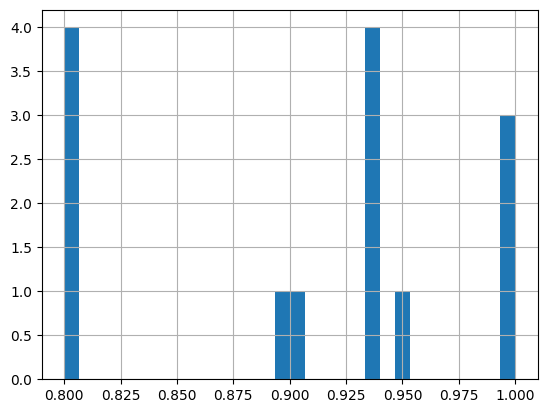

In [110]:
df3.bid2val.hist(bins=30)

<AxesSubplot: >

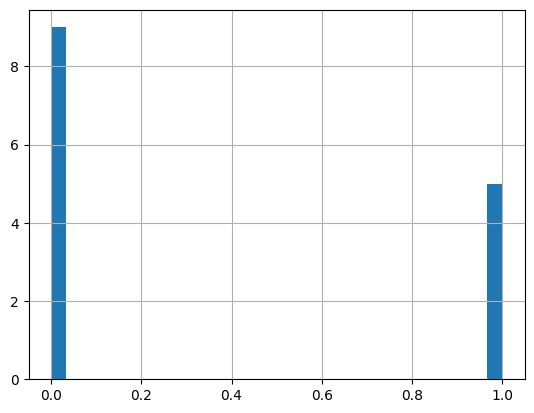

In [111]:
df3.asynchronous.hist(bins=30)

<AxesSubplot: >

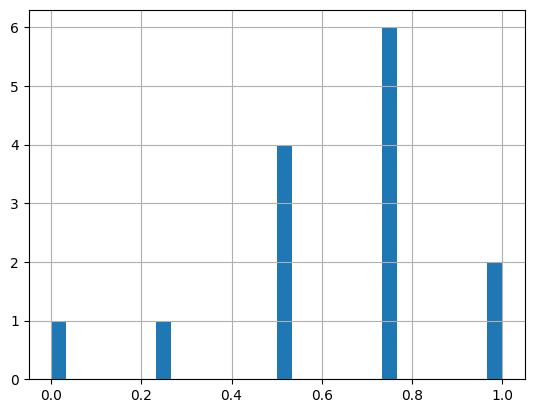

In [112]:
df3.design.hist(bins=30)

<AxesSubplot: >

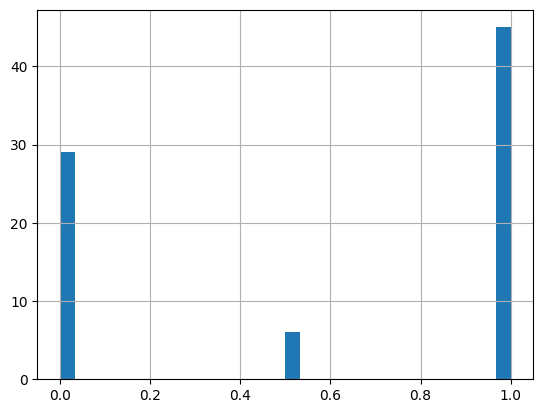

In [106]:
df3.asynchronous.hist(bins=30)

In [113]:
df3.head(20)

,bid2val,episode,Y_std,N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions
0,0.933333,317000,0.009129,2,0.050,0.99,0,0,0.50,0,16
1,0.933333,296000,0.009334,5,0.050,0.25,0,0,0.75,0,16
2,0.800000,466000,0.063822,7,0.005,0.25,1,0,0.50,1,6
3,0.933333,273000,0.009606,3,0.001,0.75,0,0,1.00,0,16
4,0.950000,273000,0.006386,7,0.010,0.00,0,0,0.25,1,21
5,0.900000,999999,0.118867,6,0.005,0.99,1,1,1.00,1,6
6,0.933333,725000,0.018275,7,0.005,0.50,1,0,0.75,1,16
7,0.800000,413000,0.039033,8,0.005,0.99,0,0,0.75,0,6
8,0.800000,439000,0.060954,2,0.005,0.00,1,0,0.50,0,6
9,0.800000,530000,0.073093,5,0.010,0.75,0,1,0.75,0,6


### Box plots

<AxesSubplot: xlabel='asynchronous', ylabel='bid2val'>

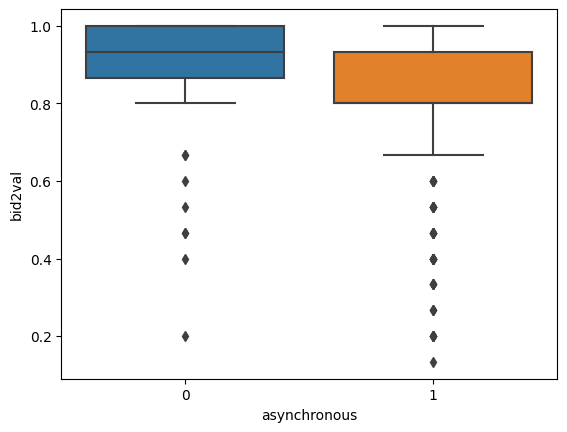

In [57]:
import seaborn as sns
sns.boxplot(data=df3, x="asynchronous", y="bid2val")

<AxesSubplot: xlabel='design', ylabel='bid2val'>

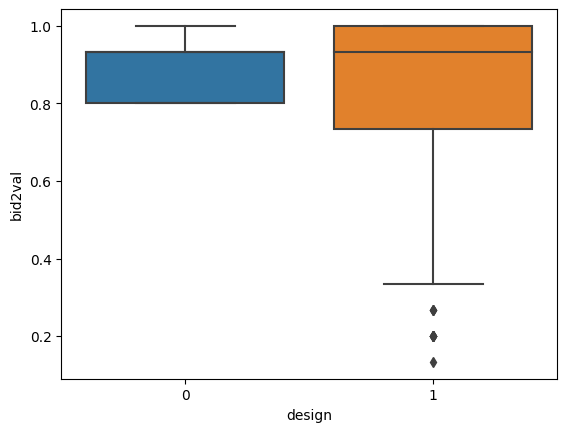

In [58]:
import seaborn as sns
sns.boxplot(data=df3, x="design", y="bid2val")

<AxesSubplot: xlabel='feedback', ylabel='bid2val'>

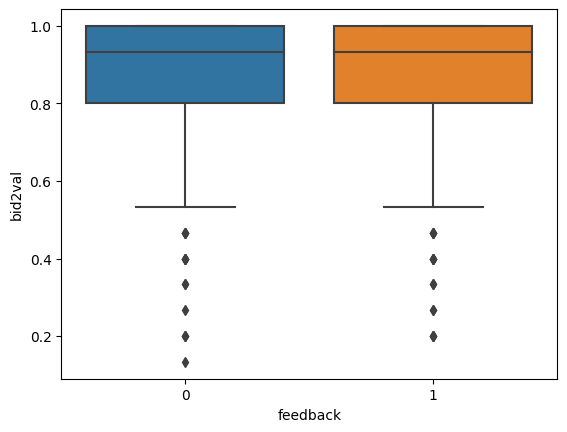

In [59]:
import seaborn as sns
sns.boxplot(data=df3, x="feedback", y="bid2val")

### Regression

In [114]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
results = smf.ols('bid2val ~ N + alpha + gamma + egreedy + design + asynchronous + feedback + num_actions', data =df3).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                bid2val   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     2.087
Date:                Thu, 25 May 2023   Prob (F-statistic):              0.217
Time:                        14:58:49   Log-Likelihood:                 26.879
No. Observations:                  14   AIC:                            -35.76
Df Residuals:                       5   BIC:                            -30.01
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7876      0.093      8.435   

kurtosistest only valid for n>=20 ... continuing anyway, n=14


### Predictive performance

In [115]:
y = df3['bid2val']
X = df3.drop(['bid2val','counterfactual'],axis=1)
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
# Create a Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100,max_depth=3)
# Define the number of folds for cross-validation
k_folds = 5
# Perform cross-validation
kf = KFold(n_splits=k_folds, shuffle=True)
cross_val_scores = cross_val_score(rf_regressor, X, y, cv=kf, scoring='r2')
# Print the performance metrics
print("Cross-validation scores:", cross_val_scores)
print("Average R-squared:", cross_val_scores.mean())

KeyError: "['counterfactual'] not found in axis"

### feature importance

In [ ]:
rf_regressor.fit(X, y)
# Get feature importances
importances = rf_regressor.feature_importances_

# Get the indices that would sort the importances in descending order
indices = np.argsort(importances)[::-1]

# Print feature importance ranking
print("Feature Importance Ranking:")
for i, idx in enumerate(indices):
    print(f"{i + 1}. Feature {idx + 1}: {importances[idx]}")

In [54]:
from sklearn.ensemble import RandomForestRegressor
import eli5
from eli5.sklearn import PermutationImportance
rf_regressor = RandomForestRegressor(n_estimators=100)
rf_regressor.fit(X, y)
perm_importance = PermutationImportance(rf_regressor).fit(X, y)
eli5.show_weights(perm_importance)

2023-05-25 11:45:35.143304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Weight,Feature
0.6599 ± 0.1727,x4
0.5920 ± 0.0796,x5
0.5521 ± 0.0518,x0
0.2416 ± 0.0453,x7
0.1632 ± 0.0672,x2
0.1566 ± 0.0182,x6
0.1525 ± 0.0755,x3
0.0986 ± 0.0527,x1


### Propensity Score Treatment Effect

In [65]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

X = df3.drop(['bid2val','asynchronous','counterfactual'],axis=1)
T  = df3['asynchronous']
# Concatenate the treatment indicator and covariates
data = pd.concat([T, X], axis=1)

# Fit a logistic regression model to estimate propensity scores
logit_model = sm.Logit(T, X)
propensity_scores = logit_model.fit().predict(X)

# Estimate the treatment effect using propensity scores
treated_outcomes = y[T == 1]
untreated_outcomes = y[T == 0]

ATE = np.mean(treated_outcomes) - np.mean(untreated_outcomes)

# Print the estimated treatment effect
print("Average Treatment Effect (ATE):", ATE)

Optimization terminated successfully.
         Current function value: 0.689209
         Iterations 4
Average Treatment Effect (ATE): -0.14227335164835175


In [67]:
from econml.dml import LinearDML
est = LinearDML()
est.fit(y, T, X=X,W=X).summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
N,0.021,0.007,3.26,0.001,0.008,0.034
alpha,0.159,0.316,0.504,0.614,-0.46,0.778
gamma,0.032,0.029,1.101,0.271,-0.025,0.089
egreedy,-0.04,0.028,-1.424,0.155,-0.096,0.015
design,-0.23,0.025,-9.096,0.0,-0.279,-0.18
feedback,0.008,0.029,0.274,0.784,-0.049,0.065
num_actions,0.0,0.003,0.078,0.938,-0.006,0.006
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-0.091,0.055,-1.661,0.097,-0.199,0.016


### Mean comparision

In [116]:
df3.groupby('N').mean()

,bid2val,episode,Y_std,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions
N,,,,,,,,,,
2,0.933333,447000.0,0.081396,0.039000,0.310,0.500000,0.25,0.5625,0.25,12.250000
3,0.933333,273000.0,0.009606,0.001000,0.750,0.000000,0.00,1.0000,0.00,16.000000
5,0.866667,413000.0,0.041214,0.030000,0.500,0.000000,0.50,0.7500,0.00,11.000000
6,0.900000,861499.5,0.113741,0.052500,0.945,1.000000,1.00,0.8750,0.50,8.500000
7,0.894444,488000.0,0.029494,0.006667,0.250,0.666667,0.00,0.5000,1.00,14.333333
8,0.900000,452500.0,0.070897,0.027500,0.990,0.500000,0.50,0.3750,0.00,8.500000


In [117]:
df3.groupby('alpha').mean()

,bid2val,episode,Y_std,N,gamma,egreedy,asynchronous,design,feedback,num_actions
alpha,,,,,,,,,,
0.001,0.966667,405000.000000,0.083863,2.5,0.375000,0.000000,0.500000,0.875000,0.0,18.500000
0.005,0.846667,608599.800000,0.060190,6.0,0.546000,0.800000,0.200000,0.700000,0.6,8.000000
0.010,0.875000,401500.000000,0.039739,6.0,0.375000,0.000000,0.500000,0.500000,0.5,13.500000
0.050,0.955556,368333.333333,0.040408,5.0,0.743333,0.333333,0.333333,0.416667,0.0,14.333333
0.100,0.950000,609000.000000,0.102998,4.0,0.575000,1.000000,0.500000,0.625000,0.5,8.500000


In [118]:
df3.groupby('gamma').mean()

,bid2val,episode,Y_std,N,alpha,egreedy,asynchronous,design,feedback,num_actions
gamma,,,,,,,,,,
0.00,0.916667,416333.333333,0.075153,3.666667,0.005333,0.333333,0.333333,0.500000,0.333333,16.000000
0.25,0.911111,419000.000000,0.056846,4.666667,0.051667,0.666667,0.000000,0.583333,0.666667,9.333333
0.50,0.933333,725000.000000,0.018275,7.000000,0.005000,1.000000,0.000000,0.750000,1.000000,16.000000
0.75,0.866667,401500.000000,0.041350,4.000000,0.005500,0.000000,0.500000,0.875000,0.000000,11.000000
0.90,0.900000,723000.000000,0.108616,6.000000,0.100000,1.000000,1.000000,0.750000,0.000000,11.000000
0.99,0.908333,555499.750000,0.067447,6.000000,0.027500,0.500000,0.500000,0.562500,0.250000,9.750000


In [119]:
df3.groupby('egreedy').mean()

,bid2val,episode,Y_std,N,alpha,gamma,asynchronous,design,feedback,num_actions
egreedy,,,,,,,,,,
0,0.907143,377000.000000,0.043529,4.571429,0.018143,0.532857,0.285714,0.678571,0.142857,14.571429
1,0.904762,619999.857143,0.081525,5.428571,0.038571,0.554286,0.428571,0.571429,0.571429,8.857143


In [120]:
df3.groupby('design').mean()

,bid2val,episode,Y_std,N,alpha,gamma,egreedy,asynchronous,feedback,num_actions
design,,,,,,,,,,
0.00,1.000000,492000.000000,0.102760,8.00,0.0500,0.9900,1.000000,1.0,0.000000,11.000000
0.25,0.950000,273000.000000,0.006386,7.00,0.0100,0.0000,0.000000,0.0,1.000000,21.000000
0.50,0.883333,429250.000000,0.057821,3.25,0.0400,0.3725,0.750000,0.0,0.500000,8.500000
0.75,0.894444,537333.333333,0.067745,5.50,0.0285,0.5650,0.333333,0.5,0.166667,12.666667
1.00,0.916667,636499.500000,0.064236,4.50,0.0030,0.8700,0.500000,0.5,0.500000,11.000000


In [121]:
df3.groupby('asynchronous').mean()

,bid2val,episode,Y_std,N,alpha,gamma,egreedy,design,feedback,num_actions
asynchronous,,,,,,,,,,
0,0.898148,410777.777778,0.034880,4.777778,0.025667,0.442222,0.444444,0.611111,0.444444,12.111111
1,0.920000,656399.800000,0.112291,5.400000,0.033200,0.726000,0.600000,0.650000,0.200000,11.000000


In [122]:
df3.groupby('feedback').mean()

,bid2val,episode,Y_std,N,alpha,gamma,egreedy,asynchronous,design,num_actions
feedback,,,,,,,,,,
0,0.900000,446666.666667,0.063405,4.555556,0.030222,0.624444,0.333333,0.444444,0.638889,12.111111
1,0.916667,591799.800000,0.060946,5.800000,0.025000,0.398000,0.800000,0.200000,0.600000,11.000000


In [123]:
df3.groupby('num_actions').mean()

,bid2val,episode,Y_std,N,alpha,gamma,egreedy,asynchronous,design,feedback
num_actions,,,,,,,,,,
6,0.850000,557166.5,0.075525,5.00,0.021667,0.538333,0.666667,0.333333,0.666667,0.50
11,0.950000,607500.0,0.105688,7.00,0.075000,0.945000,1.000000,1.000000,0.375000,0.00
16,0.933333,402750.0,0.011586,4.25,0.026500,0.622500,0.250000,0.000000,0.750000,0.25
21,0.975000,405000.0,0.082253,4.50,0.005500,0.000000,0.000000,0.500000,0.500000,0.50


### t-tests

In [80]:
import pandas as pd
import researchpy as rp
import scipy.stats as stats

In [81]:
summary, results = rp.ttest(group1= df3['bid2val'][df3['design'] == 0], group1_name= "Second Price",
         group2= df3['bid2val'][df3['design'] == 1], group2_name= "First Price")
print(summary)

       Variable      N      Mean        SD        SE  95% Conf.  Interval
0  Second Price  167.0  0.891417  0.075514  0.005843   0.879880  0.902954
1   First Price  207.0  0.808052  0.240369  0.016707   0.775113  0.840990
2      combined  374.0  0.845276  0.190182  0.009834   0.825939  0.864613


The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [83]:
print(results)

                           Independent t-test   results
0  Difference (Second Price - First Price) =     0.0834
1                       Degrees of freedom =   372.0000
2                                        t =     4.3126
3                    Two side test p value =     0.0000
4                   Difference < 0 p value =     1.0000
5                   Difference > 0 p value =     0.0000
6                                Cohen's d =     0.4486
7                                Hedge's g =     0.4477
8                           Glass's delta1 =     1.1040
9                         Point-Biserial r =     0.2182


In [88]:
stats.ttest_ind(df3['bid2val'][df3['design'] == 0],df3['bid2val'][df3['design'] == 1])

Ttest_indResult(statistic=4.312570008065045, pvalue=2.069754534801762e-05)